# Homework2

Team: AiCoders
Members:
* Alessio_Parato
* Jan31415


Task: The goal is to design and implement forecasting models to learn how to exploit past observations in the input sequences to correctly predict the future.


## Connection and Imports

### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/Colab Notebooks/Homework2/'
%cd /content/drive/MyDrive/Colab Notebooks/Homework2

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Homework2


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split

2.15.0


In [3]:
def save_model(model, model_name, path, mse=None, val_mse=None, mae=None, val_mae=None, plot=False):
  #
  #the functions saves the model and the history of a fit
  #
  if plot:
    tfk.utils.plot_model(model, to_file=path+'/model_pic.png', show_shapes=True, expand_nested=True)
  model.save(path+'/'+model_name)
  pd.DataFrame(mse).to_csv(path+'/'+model_name+'/mse.csv')
  pd.DataFrame(mae).to_csv(path+'/'+model_name+'/mae.csv')
  if val_mse!=None and val_mae!=None:
    pd.DataFrame(val_mse).to_csv(path+'/'+model_name+'/val_mse.csv')
    pd.DataFrame(val_mae).to_csv(path+'/'+model_name+'/val_mae.csv')

def load_model(path):
  #
  #the functions loads the model and the history of a fit
  #
  model = tfk.models.load_model(path)
  mse = pd.read_csv(path+'/mse.csv')
  val_mse = pd.read_csv(path+'/val_mse.csv')
  mae = pd.read_csv(path+'/mae.csv')
  val_mae = pd.read_csv(path+'/val_mae.csv')

  return (model, mse, val_mse, mae, val_mae)

## Load data

* 'training_data.npy': numpy array of shape (48000, 2776). 48000 time series of length 2776.
* 'valid_periods.npy': numpy array of type (48000, 2), containing for each of the time series the start and end index of the current series, i.e. the part without padding.
* 'categories.npy': numpy array of shape (48000,), containing for each of the time series the code of its category. The possible categories are in {'A', 'B', 'C', 'D', 'E', 'F'}.

In [4]:
#loads the unzipped dataset and divides it into data and labels
t_d = np.load('Data/training_data.npy')
cate = np.load('Data/categories.npy')
v_p = np.load('Data/valid_periods.npy')
len_v_p = v_p[:,1]-v_p[:,0]
# Print shapes of the datasets
print(f"training shape: {t_d.shape}")
print(f"categories shape: {cate.shape}")
print(f"valid_periods shape: {v_p.shape}")

training shape: (48000, 2776)
categories shape: (48000,)
valid_periods shape: (48000, 2)


### Process the dataset


In [5]:
A = np.reshape((np.where(cate=='A')), 5728)
A_train, A_v_p, A_len_v_p = t_d[A], v_p[A], len_v_p[A]
B = np.reshape((np.where(cate=='B')), 10987)
B_train, B_v_p, B_len_v_p = t_d[B], v_p[B], len_v_p[B]
C = np.reshape((np.where(cate=='C')), 10017)
C_train, C_v_p, C_len_v_p = t_d[C], v_p[C], len_v_p[C]
D = np.reshape((np.where(cate=='D')), 10016)
D_train, D_v_p, D_len_v_p = t_d[D], v_p[D], len_v_p[D]
E = np.reshape((np.where(cate=='E')), 10975)
E_train, E_v_p, E_len_v_p = t_d[E], v_p[E], len_v_p[E]
F = np.reshape((np.where(cate=='F')), 277)
F_train, F_v_p, F_len_v_p = t_d[F], v_p[F], len_v_p[F]

### Split in train, validation and test

* Training set
* Validation set
* Test set

In [6]:
def build_sequences(data, valid_periods, window=200, telescope=9, step=209):
    dataset = []
    labels = []
    da = data.copy()
    va_p = valid_periods.copy()

    for i in range(da.shape[0]):
      series = da[i,va_p[i,0]:va_p[i,1]]
      idx = 0
      while(idx+window+telescope < series.shape[0]):
        dataset.append(series[idx:idx+window])
        labels.append(series[idx+window:idx+window+telescope])
        idx = idx+step

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels
def build_sequences2(data, window=200, telescope=9, step=209):
    dataset = []
    labels = []
    da = data.copy()

    for series in da:
      idx = 0
      while(idx+window+telescope < series.shape[0]):
        dataset.append(series[idx:idx+window])
        labels.append(series[idx+window:idx+window+telescope])
        idx = idx+step

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [7]:
A_x, A_y = build_sequences(t_d[A], v_p[A], telescope=18, step=77)
print(f'Number of Training: {A_x.shape[0]}')
B_x, B_y = build_sequences(t_d[B], v_p[B],telescope=18, step=77)
print(f'Number of Training: {B_x.shape[0]}')
C_x, C_y = build_sequences(t_d[C], v_p[C],telescope=18, step=77)
print(f'Number of Training: {C_x.shape[0]}')
D_x, D_y = build_sequences(t_d[D], v_p[D],telescope=18, step=77)
print(f'Number of Training: {D_x.shape[0]}')
E_x, E_y = build_sequences(t_d[E], v_p[E],telescope=18, step=77)
print(f'Number of Training: {E_x.shape[0]}')
F_x, F_y = build_sequences(t_d[F], v_p[F],telescope=18, step=77)
print(f'Number of Training: {F_x.shape[0]}')

Number of Training: 6765
Number of Training: 5018
Number of Training: 7630
Number of Training: 9801
Number of Training: 6296
Number of Training: 196


In [8]:
test_size = 0.2
Ax_t_v, Ax_t, Ay_t_v, Ay_t = train_test_split(A_x, A_y, random_state=seed, test_size=test_size)
Bx_t_v, Bx_t, By_t_v, By_t = train_test_split(B_x, B_y, random_state=seed, test_size=test_size)
Cx_t_v, Cx_t, Cy_t_v, Cy_t = train_test_split(C_x, C_y, random_state=seed, test_size=test_size)
Dx_t_v, Dx_t, Dy_t_v, Dy_t = train_test_split(D_x, D_y, random_state=seed, test_size=test_size)
Ex_t_v, Ex_t, Ey_t_v, Ey_t = train_test_split(E_x, E_y, random_state=seed, test_size=test_size)
Fx_t_v, Fx_t, Fy_t_v, Fy_t = train_test_split(F_x, F_y, random_state=seed, test_size=test_size)

In [9]:
t_list = []
for i in range(t_d.shape[0]):
  t_list.append(t_d[i,v_p[i,0]:])
t_cor_l = []
for ele in t_list:
  t_cor_l.append(np.correlate(ele, ele))
t_cor_l = np.array(t_cor_l)

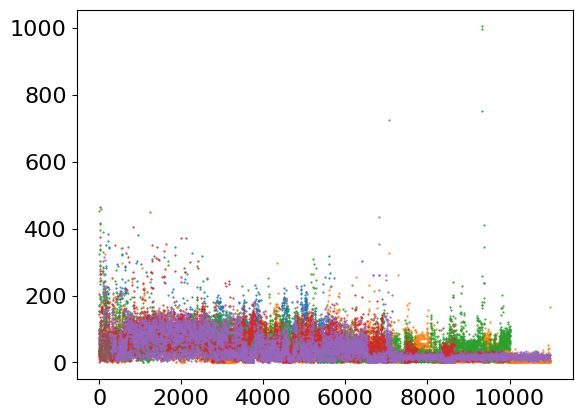

In [10]:
s = 0.3
plt.scatter(range(t_cor_l[A].shape[0]),t_cor_l[A], s=s)
plt.scatter(range(t_cor_l[B].shape[0]),t_cor_l[B], s=s)
plt.scatter(range(t_cor_l[C].shape[0]),t_cor_l[C], s=s)
plt.scatter(range(t_cor_l[D].shape[0]),t_cor_l[D], s=s)
plt.scatter(range(t_cor_l[E].shape[0]),t_cor_l[E], s=s)
plt.scatter(range(t_cor_l[F].shape[0]),t_cor_l[F], s=s)
plt.show()

In [11]:
tx, ty = build_sequences2(t_list, window=200, telescope=18, step=200)
print(tx.shape)

(23016, 200)


## Plan 2 - Connecting

The second idea was to add the trained model in the end of the attention model. In this case the attention model would decide which input points would be important.
The idea was good but the training took so much time that Colab was always cancelled.

In [14]:
model = load_model('Cate/model2')[0]
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])
model.trainable = False

In [12]:
def build_model(model):
  input_size = (200,1)

  dense_dim = 50
  embed_dim = 100
  latent_dim = 50
  num_heads = 8

  input = tfk.Input(shape=input_size, name='INPUT')

  dense_proj = tfk.Sequential([tfkl.Dense(dense_dim, activation='relu'), tfkl.Dense(embed_dim),])

  attention_output = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name='ATT')(query=input, value=input, key=input)
  proj_input = tfkl.LayerNormalization(name='Norm1')(input + attention_output)
  proj_output = dense_proj(proj_input)
  enc = tfkl.LayerNormalization(name='Norm2')(proj_input + proj_output)

  attention_output1 = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name='ATT1')(query=input, value=input, key=input)
  att1 = input + attention_output1

  attention_output2 = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name='ATT2')(query=att1,value=enc,key=enc)
  out_1 = att1 + attention_output2
  dense_out = model(out_1)

  return tfk.Model(input, dense_out, name='transformer')

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 ATT (MultiHeadAttention)    (None, 200, 1)               5601      ['INPUT[0][0]',               
                                                                     'INPUT[0][0]',               
                                                                     'INPUT[0][0]']               
                                                                                                  
 tf.__operators__.add_12 (T  (None, 200, 1)               0         ['INPUT[0][0]',               
 FOpLambda)                                                          'ATT[0][0]']       

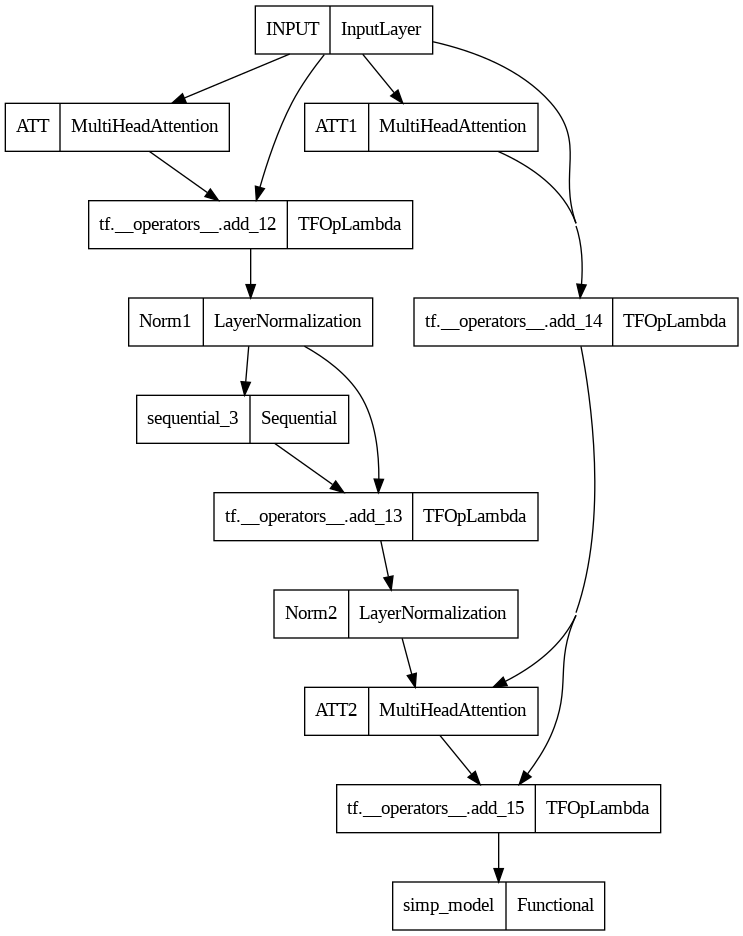

In [18]:
trans = build_model(model)
trans.compile('adam', loss='mse', metrics=['mse', 'mae'])
trans.summary()
tfk.utils.plot_model(trans, to_file='Attention/Attention_Plan2/model.png')

In [ ]:
history = trans.fit(
    x = tx,
    y = ty,
    batch_size = 128,
    epochs = 1,
    validation_split=.1
).history

162/162 [==============================] - 2290s 14s/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0474 - val_loss: 0.0114 - val_mse: 0.0114 - val_mae: 0.0676


In [ ]:
save_model(trans, 'model1', 'Attention/Attention_Plan2', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

In [ ]:
trans.get_layer('simp_model').trainable = True
trans.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 ATT (MultiHeadAttention)    (None, 200, 1)               5601      ['INPUT[0][0]',               
                                                                     'INPUT[0][0]',               
                                                                     'INPUT[0][0]']               
                                                                                                  
 tf.__operators__.add_28 (T  (None, 200, 1)               0         ['INPUT[0][0]',               
 FOpLambda)                                                          'ATT[0][0]']       

In [ ]:
history = trans.fit(
    x = tx,
    y = ty,
    batch_size = 128,
    epochs = 1,
    validation_split=.1
).history

162/162 [==============================] - 2156s 13s/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0459 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0677


In [ ]:
save_model(trans, 'model2', 'Attention/Attention_Plan2', history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

# Training

In [ ]:
def training(init_model, folder, cate, cate_Char, step1, step2, test_size = 0.2):
    x, y = build_sequences(t_d[cate], v_p[cate], window=200, telescope=18, step = step1)
    print(f'Number of Training: {x.shape[0]}')
    x_t_v, x_t, y_t_v, y_t = train_test_split(x, y, random_state=seed, test_size=test_size)

    model = load_model(folder+'/'+init_model)[0]
    model.trainable=True
    model.compile(loss='mse', optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['mse', 'mae'])
    history = model.fit(
      x = x_t_v,
      y = y_t_v,
      batch_size = 128, epochs = 20, validation_split=.1,
      callbacks = [ tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True),
                    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
    ).history
    save_model(model, 'model1_'+cate_Char, folder, history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)
    del model
    model = load_model(folder+'/model1_'+cate_Char)[0]
    model.compile(loss='mse', optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['mse', 'mae'])
    history = model.fit(
      x = x_t_v,
      y = y_t_v,
      batch_size = 64, epochs = 20, validation_split=.1,
      callbacks = [ tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True),
                    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
    ).history
    save_model(model, 'model2_'+cate_Char, folder, history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)
    del model

    model = load_model(folder+'model2_'+cate_Char)[0]
    model.compile(loss='mse', optimizer=tfk.optimizers.AdamW(learning_rate=0.001), metrics=['mse', 'mae'])
    x, y = build_sequences(t_d[cate], v_p[cate], window=200, telescope=18, step = step2)
    print(f'Number of Training: {x.shape[0]}')
    x_t_v, x_t, y_t_v, y_t = train_test_split(x, y, random_state=seed, test_size=test_size)

    history = model.fit(
      x = x_t_v,
      y = y_t_v,
      batch_size = 64, epochs = 20, validation_split=.1,
      callbacks = [ tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True),
                  tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.19, min_lr=1e-5)]
    ).history
    save_model(model, 'model3_'+cate_Char, folder, history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)

## Cate A

In [ ]:
training('model2', 'Attention/Attention_Plan2', A, 'A', step1=150, step2=90, test_size = 0.2)

Number of Training: 5062
Epoch 1/20
29/29 [==============================] - 428s 15s/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0656 - val_loss: 0.0058 - val_mse: 0.0058 - val_mae: 0.0533 - lr: 0.0010
Epoch 2/20
29/29 [==============================] - 414s 14s/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0502 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0545 - lr: 0.0010
Epoch 3/20
29/29 [==============================] - 428s 15s/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0480 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0528 - lr: 0.0010
Epoch 4/20
29/29 [==============================] - 420s 14s/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0471 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0497 - lr: 0.0010
Epoch 5/20
29/29 [==============================] - 430s 15s/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0434 - val_loss: 0.0046 - val_mse: 0.0046 - val_mae: 0.0466 - lr: 0.0010
Epoch 6/20
29/29 [==============================] - 411s 14s/step - loss: 0.0037 - mse: 0.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-c1671d74c288>", line 1, in <cell line: 1>
    training('model2', 'Cate_Plan3', A, 'A', step1=150, step2=90, test_size = 0.2)
  File "<ipython-input-13-c217741c84c4>", line 27, in training
    save_model(model, 'model2_'+cate_Char, folder, history['mse'], history['val_mse'], history['mae'], history['val_mae'], plot=False)
  File "<ipython-input-3-96eea08c7d47>", line 7, in save_model
    model.save(path+'/'+model_name)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/lib/io/file_io.py", line 513, in recursive_create_dir_v2
    _pywrap_file_io.RecursivelyCreateDir(compat.path_to_bytes(path))
tens

## Cate B

In [ ]:
training('model2', 'Attention/Attention_Plan2', B, 'B', step1=80, step2=60, test_size = 0.2)

## Cate C

In [ ]:
training('model2', 'Attention/Attention_Plan2', C, 'C', step1=150, step2=100, test_size = 0.2)

## Cate D

In [ ]:
training('model2', 'Attention/Attention_Plan2', D, 'D', step1=150, step2=100, test_size = 0.2)

## Cate E

In [ ]:
training('model2', 'Attention/Attention_Plan2', E, 'E', step1=150, step2=100, test_size = 0.2)

## Cate F

In [ ]:
training('model2', 'Attention/Attention_Plan2', F, 'F', step1=10, step2=5, test_size = 0.2)

## Validation

In [ ]:
modelA = load_model('Attention/Attention_Plan2/model3_A')[0]
print(f'Cate A:{modelA.evaluate(Ax_t, Ay_t)}')
modelB = load_model('Attention/Attention_Plan2/model3_B')[0]
print(f'Cate B:{modelB.evaluate(Bx_t, By_t)}')
modelC = load_model('Attention/Attention_Plan2/model3_C')[0]
print(f'Cate C:{modelC.evaluate(Cx_t, Cy_t)}')
modelD = load_model('Attention/Attention_Plan2/model3_D')[0]
print(f'Cate D:{modelD.evaluate(Dx_t, Dy_t)}')
modelE = load_model('Attention/Attention_Plan2/model3_E')[0]
print(f'Cate E:{modelE.evaluate(Ex_t, Ey_t)}')
modelF = load_model('Attention/Attention_Plan2/model3_F')[0]
print(f'Cate F:{modelF.evaluate(Fx_t, Fy_t)}')